The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


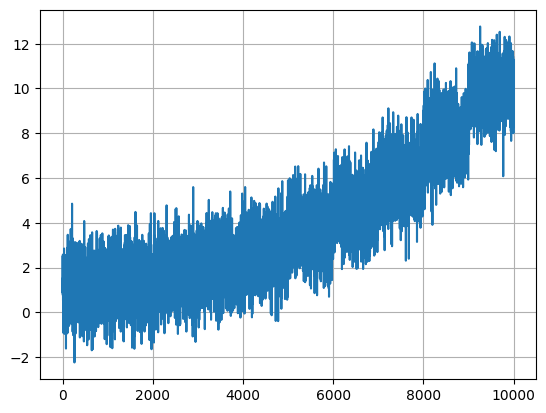

In [119]:
from __future__ import annotations

import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from river.decomposition import (
    OnlineDMD,
    OnlinePCA,
    OnlineSVD,
    OnlineSVDZhang,
)
from river.preprocessing import Hankelizer

%load_ext autoreload
%autoreload 2

# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)

# Step 1: Generate Gaussian noise with mean 0 and variance 1
gaussian_noise = np.random.normal(0, 1, (10000, 1))

# Step 2: Generate exponentially increasing X from 0 to 10
steps = np.logspace(0, 1, 10)
X = np.concatenate([np.full(1000, exp_val) for exp_val in steps])[
    :, np.newaxis
]

# Step 3: Combine the Gaussian noise with the exponential increments
X = gaussian_noise + X

# Display the result array
plt.plot(X)
plt.grid(True)

In [71]:
models = [
    OnlineDMD(r=2, seed=seed),
    OnlinePCA(n_components=2, seed=seed),
    OnlineSVD(n_components=2, seed=seed),
    OnlineSVDZhang(n_components=2, seed=seed),
]
n_feats_range = range(2, 20)
repeat = 5
iterations = len(models) * len(n_feats_range) * repeat * len(X)

In [ ]:
times_per_model_np = {model.__class__.__name__: [] for model in models}
times_per_model_pd = {model.__class__.__name__: [] for model in models}

with tqdm(total=iterations, mininterval=10) as pbar:
    for model in models:
        for n_features in n_feats_range:
            for X_iter, times_per_model_ in zip(
                [X, pd.DataFrame(X).to_dict(orient="records")],
                [times_per_model_np, times_per_model_pd]
            ):
                pipeline = Hankelizer(n_features) | model.clone()
                times = np.zeros(repeat)
                for rep in range(repeat):
                    tic = time.time()
                    for x in X_iter:
                        pipeline.transform_one(x)
                        pipeline.learn_one(x)
                        pbar.update(1)
                    times[rep] = time.time() - tic
                times_per_model_[model.__class__.__name__].append(times)

df_times_per_model_np = pd.DataFrame(times_per_model_np, index=n_feats_range)
df_times_per_model_pd = pd.DataFrame(times_per_model_pd, index=n_feats_range)

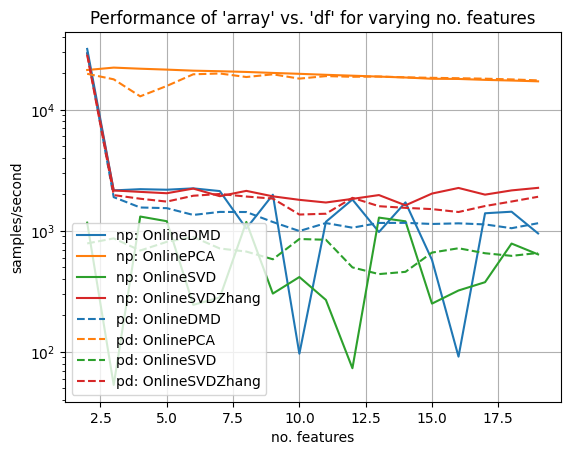

In [131]:
# [donotremove]
df_samples_per_second_np = df_times_per_model_np.map(
    lambda x: len(X) / np.mean(x)
)
df_samples_per_second_pd = df_times_per_model_pd.map(
    lambda x: len(X) / np.mean(x)
)

ax = df_samples_per_second_np.add_prefix("np: ").plot(
    grid=True,
    logy=True,
)
ax.set_prop_cycle(None)  # type: ignore
df_samples_per_second_pd.add_prefix("pd: ").plot(
    grid=True,
    logy=True,
    style="--",
    ax=ax,
)
ax.set_xlabel("no. features")
ax.set_ylabel("samples/second")
_ = ax.set_title("Performance of 'array' vs. 'df' for varying no. features")

In [121]:
# [donotremove]
# Regarding whole dataset, how much slower is pd comparing to np in abs
(df_samples_per_second_np.mean() - df_samples_per_second_pd.mean()).add_suffix(
    " (np - pd) [samples/second]"
)

OnlineDMD (np - pd) [samples/second]          241.793371
OnlinePCA (np - pd) [samples/second]         1444.972470
OnlineSVD (np - pd) [samples/second]          -58.670012
OnlineSVDZhang (np - pd) [samples/second]     309.198108
dtype: float64

In [118]:
# [donotremove]
# Regarding whole dataset, how much slower is pd comparing to np in %
(df_samples_per_second_np.mean() - df_samples_per_second_pd.mean()).add_suffix(
    " (np - pd) [%]"
) / len(X)

OnlineDMD (np - pd) [%]         0.024179
OnlinePCA (np - pd) [%]         0.144497
OnlineSVD (np - pd) [%]        -0.005867
OnlineSVDZhang (np - pd) [%]    0.030920
dtype: float64